In [7]:
import pathlib
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from numpy.linalg import svd
from scipy.stats import norm

from scipy.ndimage import convolve1d, gaussian_filter1d, uniform_filter1d
DATA_DIR = "/Users/matzhaugen/schumann/"



In [4]:
# To download data
do_url = "https://subsub.fra1.digitaloceanspaces.com/GCI00{i}.zip"
import requests, zipfile, io
for i in range(1,7):
    print(f"Downloading {do_url}")
    r = requests.get(do_url.format(i=i))
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(DATA_DIR)

In [33]:
f"{DATA_DIR}GCI001/*.txt"

'/Users/matzhaugen/schumann/GCI001/*.txt'

In [35]:
import os
os.getcwd()

'/Users/matzhaugen/mortality/notebooks'

In [55]:
# Here we analyse california
INDEX = 1
files = []
for path in pathlib.Path(DATA_DIR).glob(f"GCI00{INDEX}/*.txt"):
    if path.is_file():
        files.append(path)

In [42]:
patterns = '_(\d+)_(\d+)_(\d+)'
# re.search('(d+)_(d+)_(d+)', str(files[0])).group[0]
month_day = [(int(re.search(patterns, str(f)).group(2)), int(re.search(patterns, str(f)).group(3))) for f in files]

In [43]:
def read_data(f: pathlib.Path) -> pd.DataFrame:
    month = re.search(patterns, str(f)).group(2)
    day = re.search(patterns, str(f)).group(3)
    year = re.search(patterns, str(f)).group(1)
    date = np.datetime64(f"{year}-{month}-{day}")
    data = pd.read_csv(f, delimiter="\t")
    data = data.rename({"-10": "freq"}, axis=1)
    pivot = data.T
    pivot = pivot.iloc[1:,:]
    hour = [f"{int(s)-1}" if int(s) > 10 else f"0{int(s)-1}" for s in pivot.index]
    datetime = [np.datetime64(f"{year}-{month}-{day} {h}:00:00") for h in hour]
    pivot.index = datetime
    return pivot

def read_freq(f) -> pd.DataFrame:
    freq = pd.read_csv(f, delimiter="\t", usecols=[0])
    return freq.values

In [44]:
freqs = [read_freq(f) for f in files]
master_freq = np.copy(freqs[0])
master_freq = master_freq.flatten()

In [45]:
bad_days = []
for i, f in enumerate(freqs):
    if len(f) != len(master_freq):
        bad_days.append(i)
        
all_data = pd.concat([read_data(f) if i not in bad_days else pd.DataFrame() for i, f in enumerate(files)])


In [46]:
df = all_data.sort_index()
removelist = np.concatenate([np.arange(np.datetime64('2020-04-16'), np.datetime64('2020-05-06')),
                       np.arange(np.datetime64('2019-03-18'), np.datetime64('2019-04-09'))])
mask = ~np.in1d(df.index.date, pd.to_datetime(removelist).date)
df = df.iloc[mask,]

<Axes: >

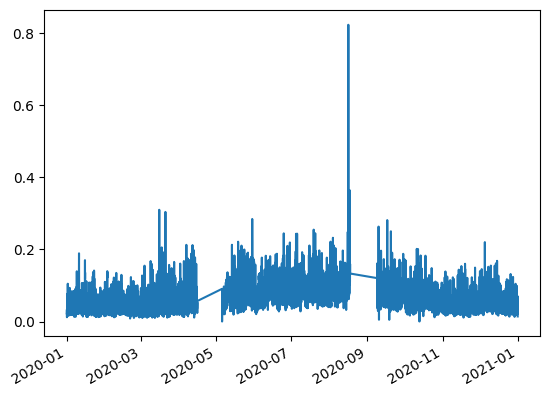

In [47]:
df.iloc[:,-1]["2020"].plot()

Text(0.5, 0, 'Time [hour]')

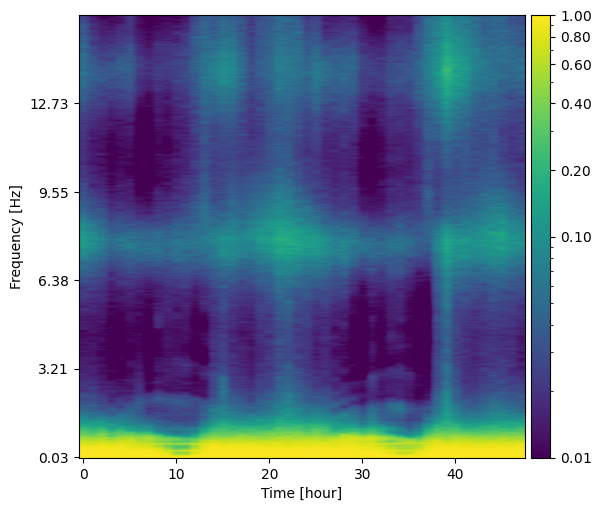

In [48]:
from matplotlib.colors import LogNorm

f = plt.figure(figsize=(6.2, 5.6))
ax = f.add_axes([0.17, 0.02, 0.72, 0.79])
axcolor = f.add_axes([0.90, 0.02, 0.03, 0.79])
C = df.loc["2020-03-05":"2020-03-06"].values[:,:500]
im = ax.imshow(C.T,  norm=LogNorm(vmin=0.01, vmax=1), aspect="auto", origin="lower")

t = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
f.colorbar(im, cax=axcolor, ticks=t, format="$%.2f$")

# f.show()

# imgplot = plt.imshow(np.log(df.loc["2020-03-05"].values), aspect="auto")
# plt.show()
plot_freqs = np.round(master_freq[np.arange(0, 500, 100, dtype=int)].flatten(), 2)
ax.set_yticks(np.arange(0, 500, 100))
ax.set_yticklabels(plot_freqs)
ax.set_ylabel("Frequency [Hz]")
ax.set_xlabel("Time [hour]")

In [49]:
import sympy as sp

# define symbolic variable
a_i, f_i, w_i, x = sp.symbols('a_i f_i w_i x')

# define symbolic equation
eq = a_i / (1 + (2 * (x - f_i) / w_i) ** 2)

# find fourth order derivative
print(eq.diff(a_i))
print(eq.diff(f_i))
print(eq.diff(w_i))


1/(1 + (-2*f_i + 2*x)**2/w_i**2)
-a_i*(8*f_i - 8*x)/(w_i**2*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)
2*a_i*(-2*f_i + 2*x)**2/(w_i**3*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)


In [50]:

from scipy.optimize import curve_fit
def lorentz1(x, f1, a1, w1):
    amplitude = np.zeros_like(x)

    amplitude = a1 / (1 + np.power((2 * (x - f1) / w1), 2))
    return amplitude

def jac_lorentzian1(x, f_i, a_i, w_i):
    
    J = np.zeros((x.size, 3))
    J[:, 0] = -a_i*(8*f_i - 8*x)/(w_i**2*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)
    J[:, 1] = 1/(1 + (-2*f_i + 2*x)**2/w_i**2)
    J[:, 2] = 2*a_i*(-2*f_i + 2*x)**2/(w_i**3*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)

    return J

def lorentz2(x, f1,f2,
            a1, a2, 
            w1, w2):
    amplitude = np.zeros_like(x)
    f = np.array([f1, f2])
    a = np.array([a1, a2])
    w = np.array([w1, w2])
    for a_i, f_i, w_i in zip(a, f, w):
        amplitude += a_i / (1 + np.power((2 * (x - f_i) / w_i), 2))
    return amplitude

def jac_lorentzian2(x, f1, f2, 
            a1, a2, 
            w1, w2):
    
    J = np.zeros((x.size, 2 * 3))
    f = np.array([f1, f2])
    a = np.array([a1, a2])
    w = np.array([w1, w2])
    for i, (a_i, f_i, w_i) in enumerate(zip(a, f, w)):
        J[:, i] += -a_i*(8*f_i - 8*x)/(w_i**2*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)
        J[:, i + 2] += 1/(1 + (-2*f_i + 2*x)**2/w_i**2)
        J[:, i + 2*2] += 2*a_i*(-2*f_i + 2*x)**2/(w_i**3*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)

    return J

def lorentz5(x, f1, f2, f3, f4, f5, 
            a1, a2, a3, a4, a5, 
            w1, w2, w3, w4, w5):
    amplitude = np.zeros_like(x)
    f = np.array([f1, f2, f3, f4, f5])
    a = np.array([a1, a2, a3, a4, a5])
    w = np.array([w1, w2, w3, w4, w5])
    for a_i, f_i, w_i in zip(a, f, w):
        amplitude += a_i / (1 + np.power((2 * (x - f_i) / w_i), 2))
    return amplitude

def jac_lorentzian5(x, f1, f2, f3, f4, f5, 
            a1, a2, a3, a4, a5, 
            w1, w2, w3, w4, w5):
    
    J = np.zeros((x.size, 5 * 3))
    f = np.array([f1, f2, f3, f4, f5])
    a = np.array([a1, a2, a3, a4, a5])
    w = np.array([w1, w2, w3, w4, w5])
    for i, (a_i, f_i, w_i) in enumerate(zip(a, f, w)):
        J[:, i] += -a_i*(8*f_i - 8*x)/(w_i**2*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)
        J[:, i + 5] += 1/(1 + (-2*f_i + 2*x)**2/w_i**2)
        J[:, i + 2*5] += 2*a_i*(-2*f_i + 2*x)**2/(w_i**3*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)

    return J

def lorentz(x, f1, f2, f3, f4, f5, f6, 
            a1, a2, a3, a4, a5, a6, 
            w1, w2, w3, w4, w5, w6):
    amplitude = np.zeros_like(x)
    f = np.array([f1, f2, f3, f4, f5, f6])
    a = np.array([a1, a2, a3, a4, a5, a6])
    w = np.array([w1, w2, w3, w4, w5, w6])
    for a_i, f_i, w_i in zip(a, f, w):
        amplitude += a_i / (1 + np.power((2 * (x - f_i) / w_i), 2))
    return amplitude

def jac_lorentzian(x, f1, f2, f3, f4, f5, f6, 
            a1, a2, a3, a4, a5, a6, 
            w1, w2, w3, w4, w5, w6):
    
    J = np.zeros((x.size, 6 * 3))
    f = np.array([f1, f2, f3, f4, f5, f6])
    a = np.array([a1, a2, a3, a4, a5, a6])
    w = np.array([w1, w2, w3, w4, w5, w6])
    for i, (a_i, f_i, w_i) in enumerate(zip(a, f, w)):
        J[:, i] += -a_i*(8*f_i - 8*x)/(w_i**2*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)
        J[:, i + 6] += 1/(1 + (-2*f_i + 2*x)**2/w_i**2)
        J[:, i + 2*6] += 2*a_i*(-2*f_i + 2*x)**2/(w_i**3*(1 + (-2*f_i + 2*x)**2/w_i**2)**2)

    return J

def find_peaks(a_hat):
    da_hat = np.diff(a_hat)
    peaks = np.abs(da_hat) < 0.005
    idx = peaks * np.arange(len(peaks))
    has_left_zero = idx[1:][idx[:-1] * idx[1:] == 0]
    has_right_zero = idx[:-1][idx[:-1] * idx[1:] == 0]
    max_peaks = np.minimum(sum(has_left_zero != 0), sum(has_right_zero != 0))
    true_peaks = ((has_left_zero[has_left_zero != 0][:max_peaks] + has_right_zero[has_right_zero != 0][:max_peaks]) / 2).astype(int)
    return true_peaks + 1

def find_peaks2(a_hat):
    da_hat = np.diff(a_hat)
    has_swap = da_hat[:-1] * da_hat[1:] < 0
    is_max = has_swap * (da_hat[:-1] > 0)
    return np.arange(len(da_hat) - 1)[is_max] + 1


def ffill(x, na_val=0):
    a = x.copy()
    # find zero elements and associated index
    if np.isnan(na_val):
        mask = np.isnan(a)
    else:
        mask = a == na_val
    idx = np.where(~mask, np.arange(mask.size), False)

    # do the fill
    return a[np.maximum.accumulate(idx)]


def scale(arr):
    return np.apply_along_axis(lambda x: (x - np.mean(x)) / np.std(x), arr=arr, axis=0)


def maf(x):
    """Compute the maf factors of a set of time series
    Input: x(np.array/pd.dataframe) dimensions n-by-p with p n-length time series
    Output: f(np.array) Maf factors, i.e. the rotated time series such that the first column
    is the linear combination of the original time series that maximizes autocorrelation. The
    second column maximizes autocorrelation and is also orthogonal to the first time series.
            w (p-by-p np.array) - maf weights, or the loadings of each original time series.
        Each column represents a maf factor.
    """
    x = np.asarray(x)
    n, p = x.shape
    if n - 1 < p:
        raise ValueError("Not enough observations to estimate weights")
    s = np.cov(x.T)
    u, d, v = svd(s)
    nz = d>0
    a = np.dot(np.dot(u[:, nz], np.diag(np.power(d[nz], -0.5))), u[:, nz].T)
    y = np.dot(x, a)
    dy = np.diff(y, n=1, axis=0)
    sy = np.cov(dy.T)
    uy, dy, vy = svd(sy)
    nzy = dy>0
    w = np.fliplr(np.dot(a, uy))
    w = np.array([wi / np.sqrt(sum(wi ** 2)) for wi in w[:, nzy[::-1]].T]).T

    f = np.dot(x, w)

    # We disambiguate the mafs by correlating the maf factors with a linear function
    # with time, i.e. 1:t where t is the number of time steps.
    flip = np.sum(np.diff(f, axis=0), axis=0) > 0
    flip = flip.astype(int) * 2 - 1
    w = w * flip[np.newaxis, :]
    f = np.dot(x, w)

    return f, w

In [51]:
x = df.loc["2020-04-19"].values.T
x = np.asarray(x)
n, p = x.shape
if n - 1 < p:
    raise ValueError("Not enough observations to estimate weights")
s = np.cov(x.T)
u, d, v = svd(s)
nz = d>0
a = np.dot(np.dot(u[:, nz], np.diag(np.power(d[nz], -0.5))), u[:, nz].T)
y = np.dot(x, a)
dy = np.diff(y, n=1, axis=0)
sy = np.cov(dy.T)
uy, dy, vy = svd(sy)
nzy = dy>0
w = np.fliplr(np.dot(a, uy))
w = np.array([wi / np.sqrt(sum(wi ** 2)) for wi in w[:, nzy[::-1]].T]).T

f = np.dot(x, w)

# We disambiguate the mafs by correlating the maf factors with a linear function
# with time, i.e. 1:t where t is the number of time steps.
flip = np.sum(np.diff(f, axis=0), axis=0) > 0
flip = flip.astype(int) * 2 - 1
w = w * flip[np.newaxis, :]
f = np.dot(x, w)

IndexError: invalid index to scalar variable.

In [53]:
def get_characteristics(
    values,
    freqs,
    max_peaks = 5,
    window_freq = (6.75, 9),  # The specific frequency window to look at a peak in
    min_freq = 1, # Hz  - The overall frequency range to analyse
    max_freq = 30,  # - The overall frequency range to analyse
    filter_width = 20, # width in peak finding filter
    post_filter_width = 72, # width in filter of output
):
    sub_idx = np.logical_and(min_freq < freqs, freqs < max_freq)
    sub_freq = freqs[sub_idx]
    subset = values[:, sub_idx]
    
    values += 0.0001
    proc_data = np.log(subset * np.exp(5))
    n_times, n_freq = proc_data.shape

    peaks = np.zeros((n_times, max_peaks))
    main_peak = np.zeros(n_times)
    main_freq = np.zeros(n_times)
    main_var = np.zeros(n_times)
    peak_freq = np.zeros((n_times, max_peaks))
    for i, obs in enumerate(proc_data):
        a_hat = gaussian_filter1d(obs, filter_width)
        peaks_i = find_peaks2(a_hat)
        n_peaks = np.minimum(len(peaks_i), max_peaks)
        if n_peaks > 0:
            peaks[i, :n_peaks] = a_hat[peaks_i[:n_peaks]]
            peak_freq[i, :n_peaks] = sub_freq[peaks_i[:n_peaks]]
            main_idx = np.logical_and(window_freq[0] < peak_freq[i, :], peak_freq[i, :] < window_freq[1])
            if sum(main_idx) > 0:
                main_peak[i] = peaks[i, main_idx][0]
                main_freq[i] = peak_freq[i, main_idx][0]
                window = np.logical_and(sub_freq > main_freq[i] - .5, sub_freq < main_freq[i] + .5)
                main_var[i] = np.std((obs - a_hat)[window])
                
    final_freq = uniform_filter1d(ffill(main_freq), post_filter_width)
    final_amp = uniform_filter1d(ffill(main_peak), post_filter_width)
    final_var = uniform_filter1d(ffill(main_var), post_filter_width)

    return final_amp, final_freq, final_var
         
def plot_characteristics(dates, final_amp, final_freq, final_var):
    fig, axs = plt.subplots(1, 3, figsize=(25,5))
    
    axs[2].plot(dates, final_var, label="Variance")
    axs[0].plot(dates, final_amp, color="green", label="Amplitude")
    axs[1].plot(dates, final_freq, color="red", label="Peak Freq.")   
    
    axs[0].set_title("Amplitude and Variance")
    axs[0].set_ylabel("Amplitude [pT]")
    axs[1].set_ylabel("Peak Freq [Hz]")
    axs[2].set_ylabel("Variance [pT]")
    axs[1].set_title("Peak Frequency")
    fig.autofmt_xdate()  # type: ignore
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # type: ignore
    axs[0].legend(loc="upper left")
    axs[2].legend(loc="best")
    axs[1].legend()
    fig.tight_layout()
    return fig, axs

/var/folders/3d/mrj5ym354zl424bqr1073p1w0000gq/T/ipykernel_36423/2433188602.py:16: RuntimeWarning: divide by zero encountered in log
  proc_data = np.log(subset * np.exp(5))
/Users/matzhaugen/.pyenv/versions/3.9.5/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


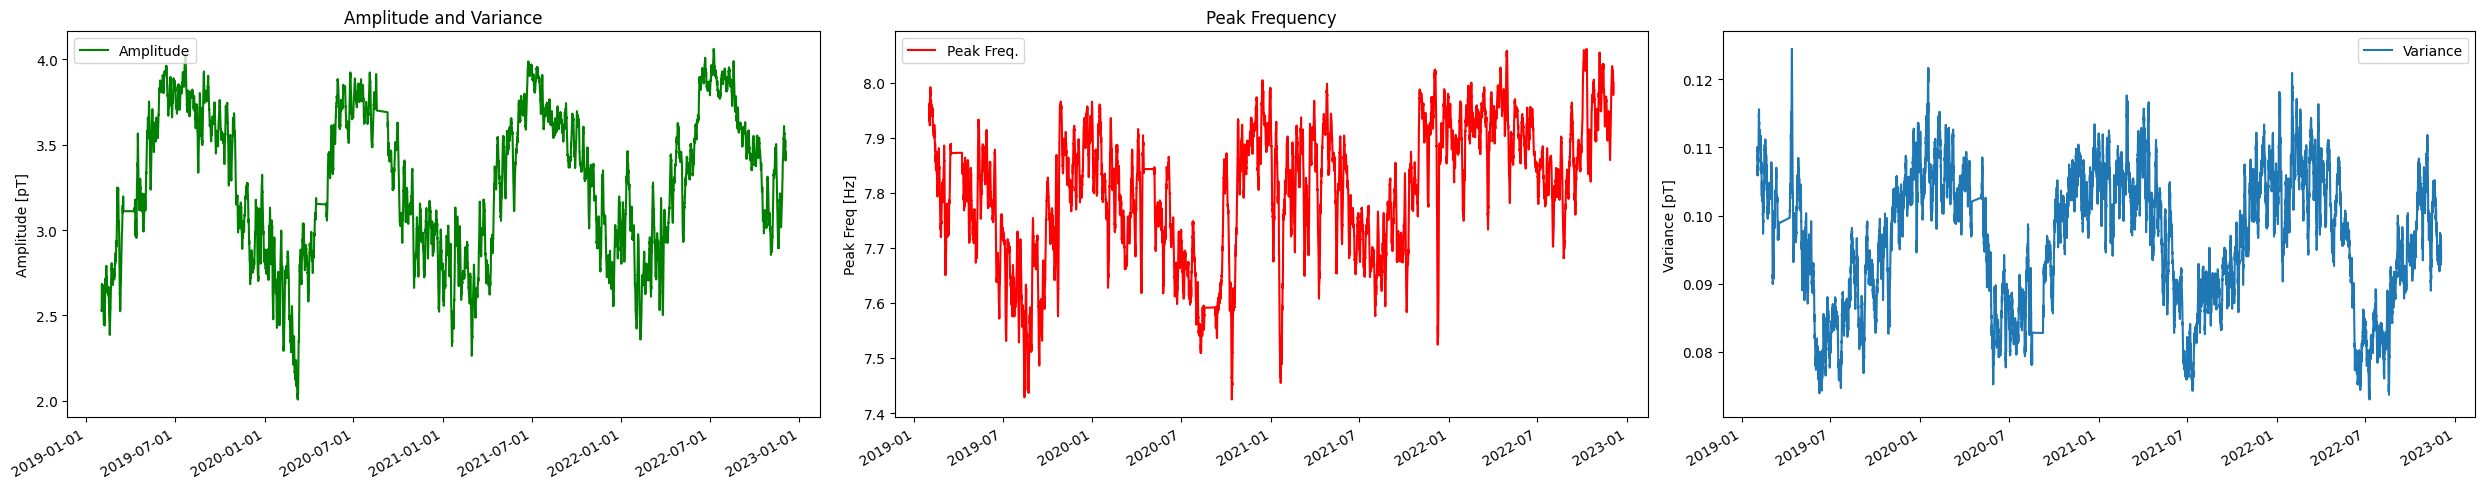

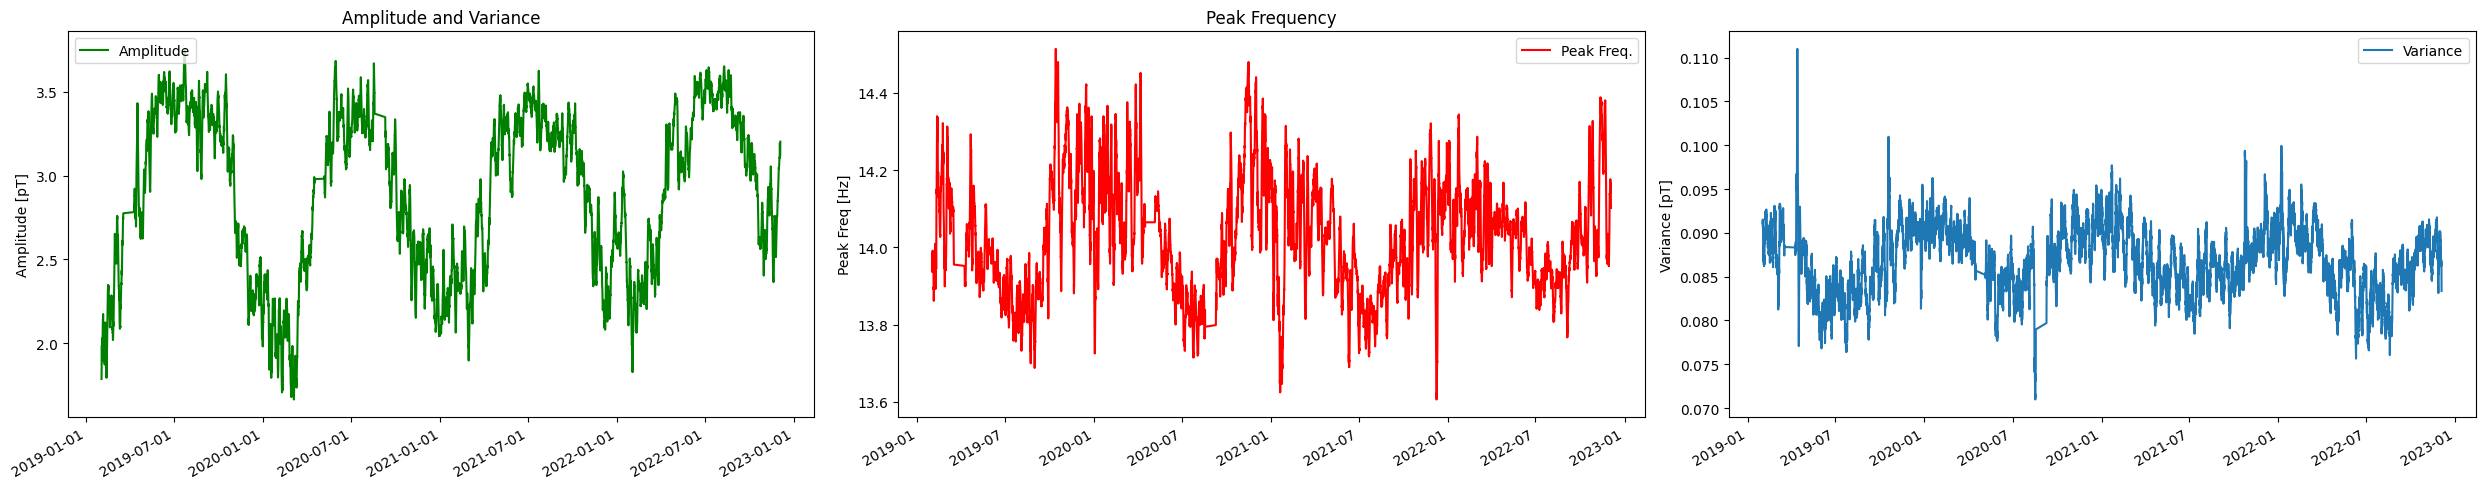

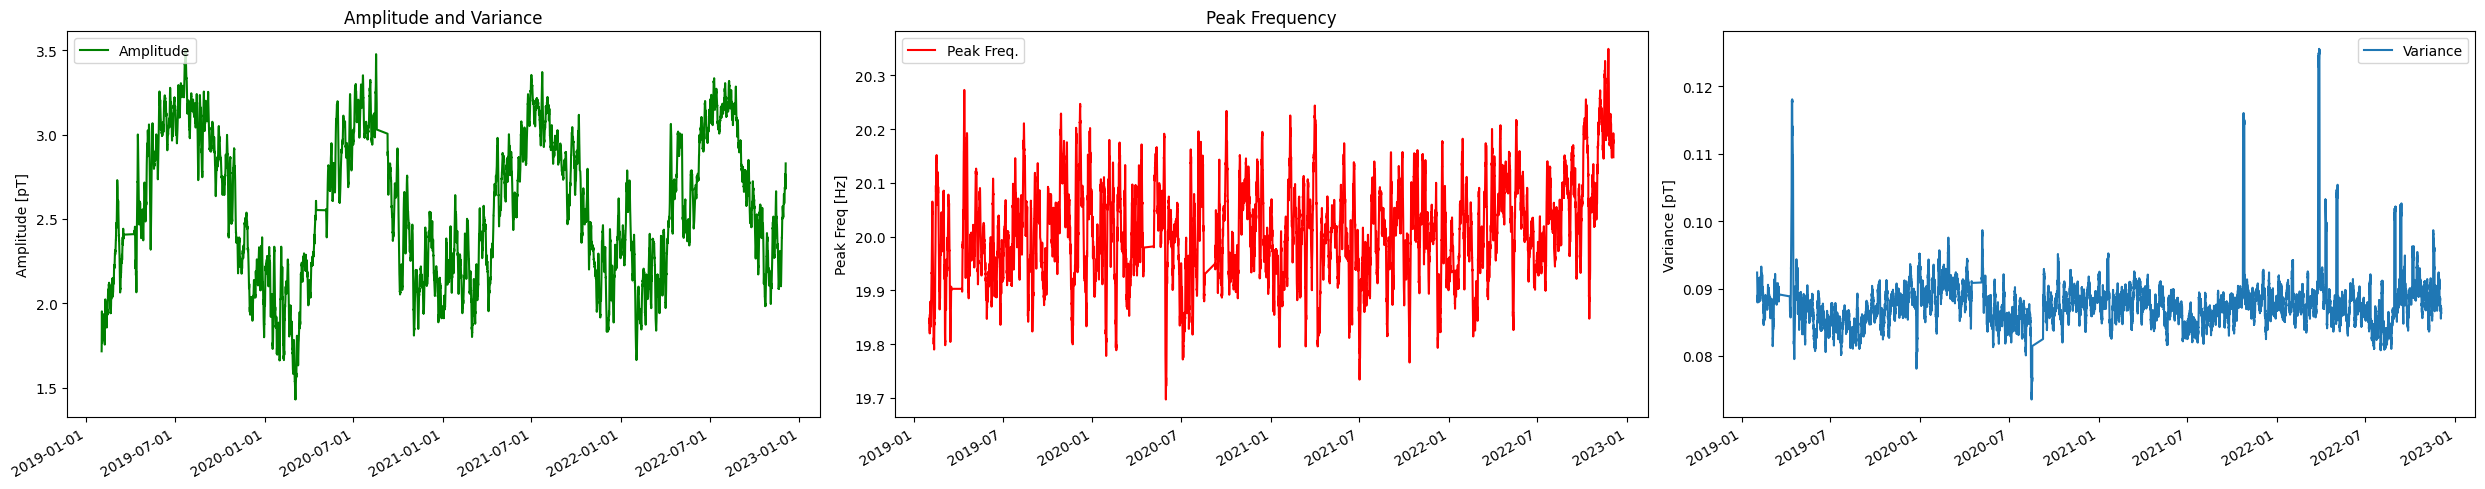

In [54]:
start_date = "2019-02-01"
end_date = "2022-12-03"
values = df.loc[start_date:end_date].values
dates = df.loc[start_date:end_date].index.values
characteristics = get_characteristics(values, master_freq)
h1 = plot_characteristics(dates, *characteristics)
characteristics2 = get_characteristics(values, master_freq,
                                                      window_freq = (12, 16))
h2 = plot_characteristics(dates, *characteristics2)
characteristics3 = get_characteristics(values, master_freq,
                                                      window_freq = (17, 22))
h3 = plot_characteristics(dates, *characteristics3)


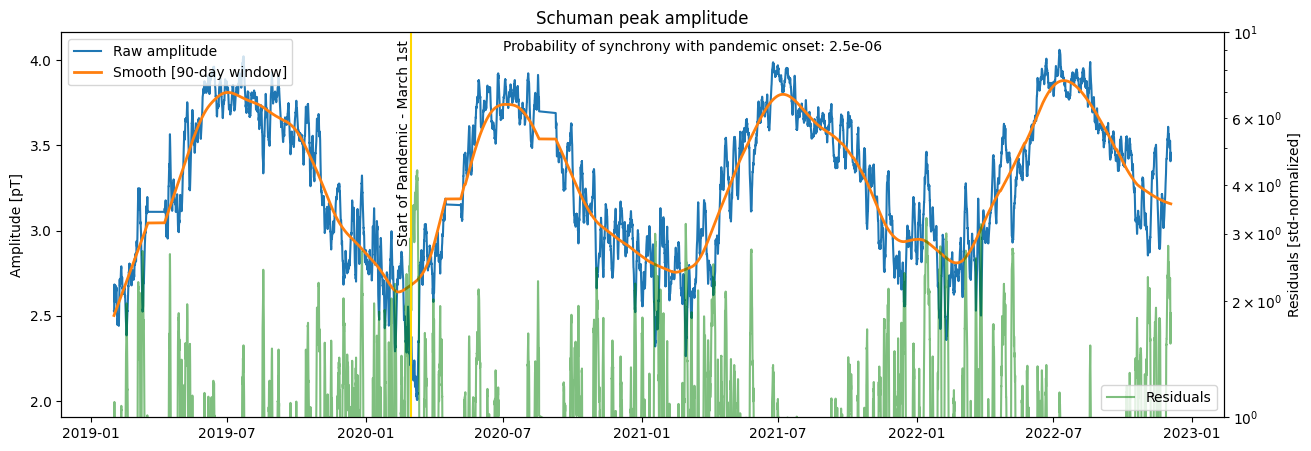

In [56]:
from statsmodels.nonparametric.smoothers_lowess import lowess
N_DAYS_FILTER = 90
fig, axs = plt.subplots(1, 1, figsize=(15,5))
y = characteristics[0]
x = np.arange(len(y))
frac = 24*N_DAYS_FILTER / len(y)
yhat = lowess(y, x, frac=frac, return_sorted=False)
res = np.abs(y - yhat)
sigma_hat = np.sqrt(np.mean(np.power(res, 2)))
# z = lowess(res / sigma_hat, x, frac=frac)[:, 1]
z = res / sigma_hat
plt.plot(dates, y, label="Raw amplitude")
plt.plot(dates, yhat, label="Smooth [90-day window]", linewidth=2)
plt.legend(loc="upper left")
plt.title("Schuman peak amplitude")
plt.ylabel("Amplitude [pT]")
ax = plt.gca()
twin = ax.twinx()
# twin.plot(dates[z>3], z[z>3], color="red", alpha=0.3)
twin.plot(dates, z, color="green", alpha=0.5, label="Residuals")
twin.set_yscale('log')
twin.set_ylim([1,10])
twin.set_ylabel("Residuals [std-normalized]")
twin.legend(loc="lower right")
plt.axvline(np.datetime64("2020-03-01"), color="gold")
ax.text(np.datetime64("2020-03-01"), 0.98, 'Start of Pandemic - March 1st', color='black', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform(), fontsize=10)

prob = 1 / 200 * 1 / 2000
ax.text(np.datetime64("2020-07-01"), 0.98, f'Probability of synchrony with pandemic onset: {prob} ', color='black', ha='left', 
        transform=ax.get_xaxis_transform(), va='top', rotation=0, fontsize=10)

plt.savefig(f"../figures/SchumannAmplitude_{INDEX}.jpg")
# for s, e in zip(start_times, end_times):
    
#     plt.axvspan(dates[s], dates[e], facecolor='gold', alpha=0.5)

In [374]:
# start_times = np.concatenate(x[z>3][0], x[np.diff(x[z>3]) != 1] + 1)
x[z>3]
idx = np.insert(np.diff(x[z>3]) != 1, 0, True)
start_times = x[z>3][idx]
idx_end = np.roll(np.insert(np.diff(x[z>3]) != 1, 0, False), -1)
idx_end
end_times = x[z>3][idx_end]
end_times
# end_times = x[np.diff(x[z>3]) != 1]
# start_times = np.diff(x[z>3]) != 1

array([ 9135, 15687, 24191, 24194, 24290, 31847])

In [377]:
start_times

array([ 8887, 15679, 24189, 24194, 24209, 31842, 31864])

2019-10-01
2020-10-01


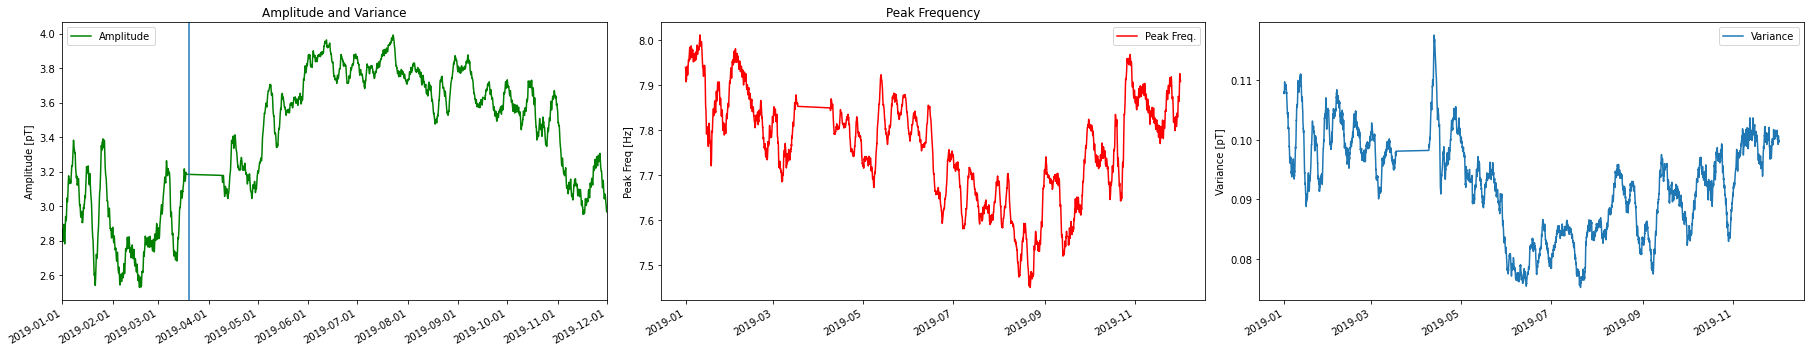

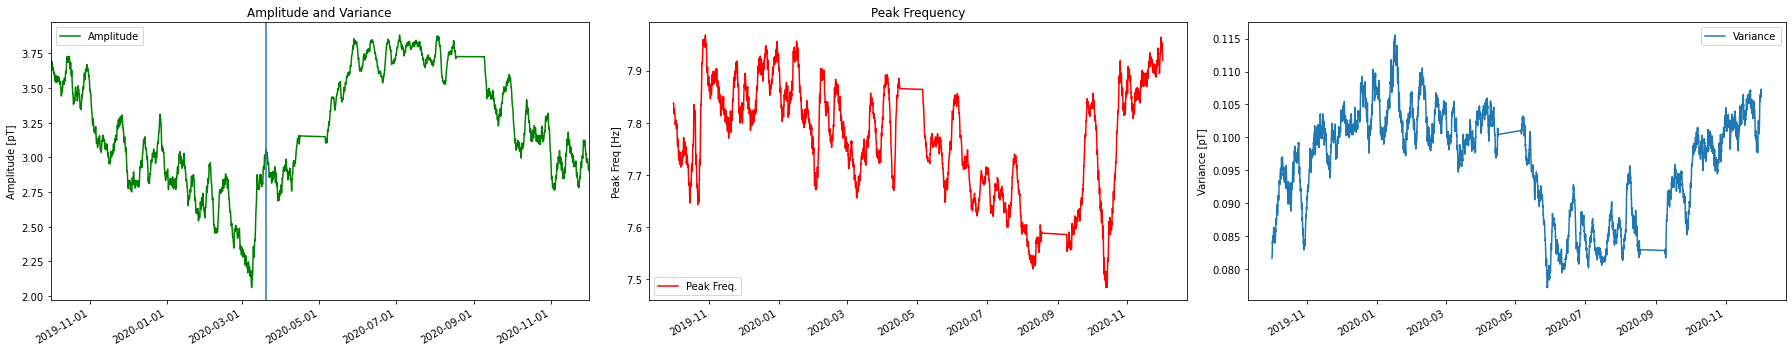

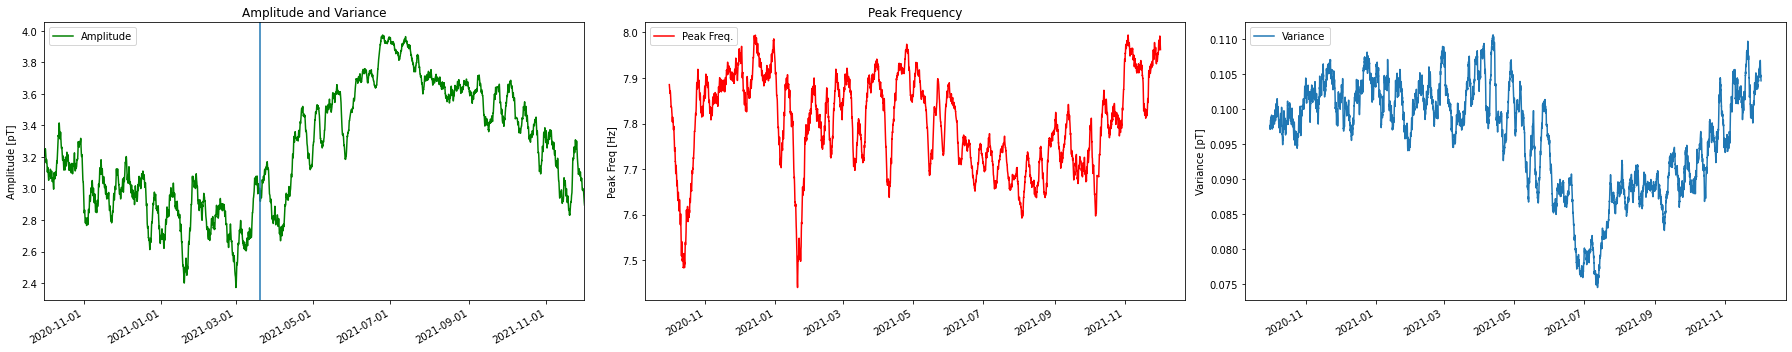

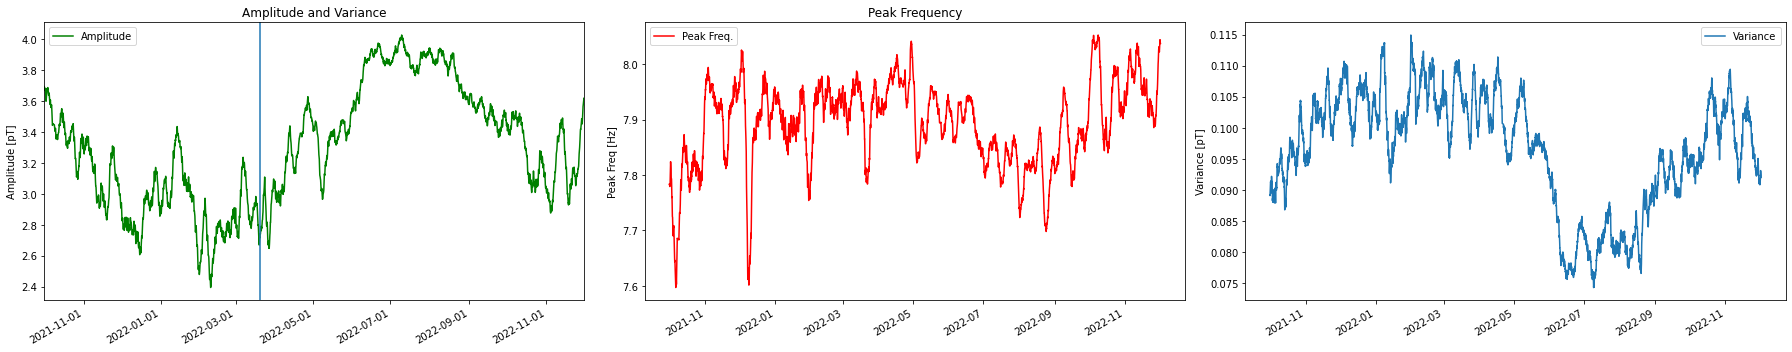

In [326]:
year = 2019
start_date = "{}-10-01"
end_date =  "{}-12-01"
special_date = "{}-03-20"

end_year = 2019
values = df.loc["2019-01-01":end_date.format(year)].values
dates = df.loc["2019-01-01":end_date.format(year)].index.values
characteristics = get_characteristics(values, master_freq)
h1 = plot_characteristics(dates, *characteristics)
h1[1][0].axvline(np.datetime64(special_date.format(end_year)))
h1[1][0].set_xlim([np.datetime64("2019-01-01"), np.datetime64(end_date.format(year))])

year = 2019
end_year = 2020
print(start_date.format(year))
values = df.loc[start_date.format(year):end_date.format(end_year)].values
dates = df.loc[start_date.format(year):end_date.format(end_year)].index.values
characteristics = get_characteristics(values, master_freq)
h2 = plot_characteristics(dates, *characteristics)
h2[1][0].set_xlim([np.datetime64(start_date.format(year)), np.datetime64(end_date.format(end_year))])
h2[1][0].axvline(np.datetime64(special_date.format(end_year)))

year = 2020
end_year = 2021
print(start_date.format(year))
values = df.loc[start_date.format(year):end_date.format(end_year)].values
dates = df.loc[start_date.format(year):end_date.format(end_year)].index.values
characteristics = get_characteristics(values, master_freq)
h3 = plot_characteristics(dates, *characteristics)
h3[1][0].set_xlim([np.datetime64(start_date.format(year)), np.datetime64(end_date.format(end_year))])
h3[1][0].axvline(np.datetime64(special_date.format(end_year)))

year = 2021
end_year = 2022
values = df.loc[start_date.format(year):end_date.format(end_year)].values
dates = df.loc[start_date.format(year):end_date.format(end_year)].index.values
characteristics = get_characteristics(values, master_freq)
h4 = plot_characteristics(dates, *characteristics)
h4[1][0].set_xlim([np.datetime64(start_date.format(year)), np.datetime64(end_date.format(end_year))])
h4[1][0].axvline(np.datetime64(special_date.format(end_year)))

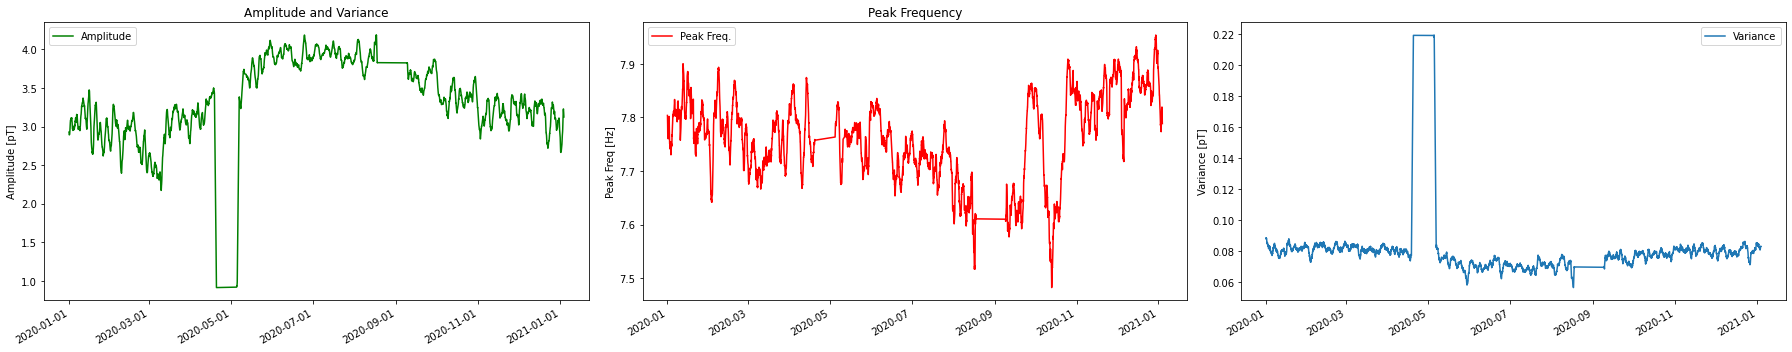

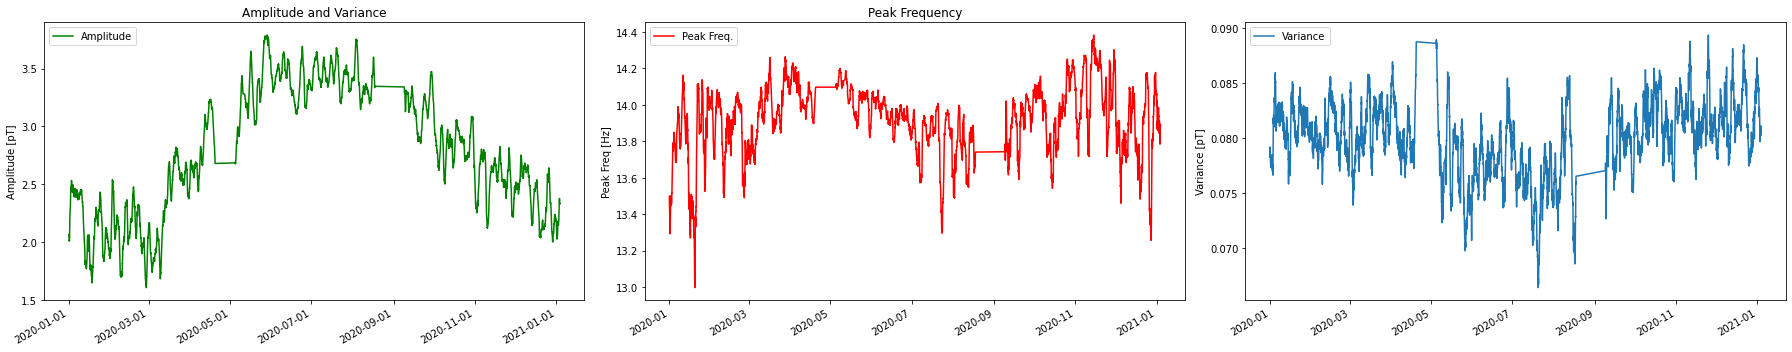

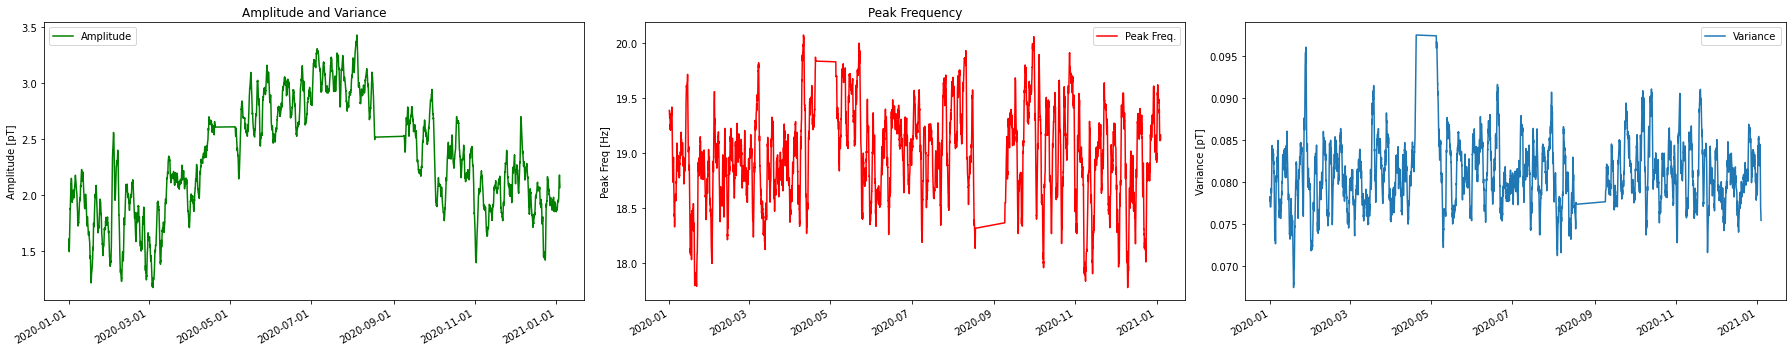

In [204]:

start_date = "2019-01-01"
end_date = "2021-01-03"
# Filter not needed
# values = uniform_filter1d(df.loc[start_date:end_date].values, size=24, axis=0)
values = df.loc[start_date:end_date].values
dates = df.loc[start_date:end_date].index.values
characteristics = get_characteristics(values, master_freq)
h1 = plot_characteristics(dates, *characteristics)
characteristics2 = get_characteristics(values, master_freq,
                                                      window_freq = (12, 16))
h2 = plot_characteristics(dates, *characteristics2)
characteristics3 = get_characteristics(values, master_freq,
                                                      window_freq = (17, 22))
h3 = plot_characteristics(dates, *characteristics3)


(<Figure size 720x144 with 1 Axes>, [<AxesSubplot:>])

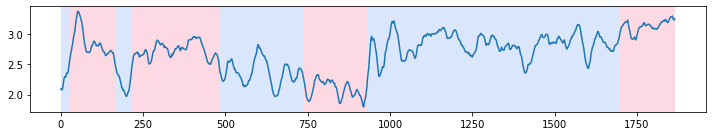

In [17]:
# Change point detection
import ruptures as rpt

signal = final_amp
# detection
algo = rpt.Pelt(model="l1").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, result)

(0.0, 2.0)

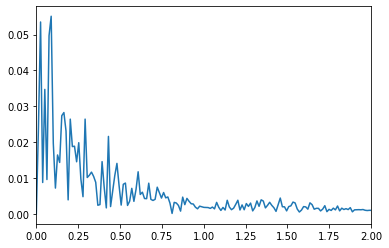

In [160]:
from scipy import fftpack
y = uniform_filter1d(ffill(main_freq), 24)
y -= np.mean(y)
# Number of samplepoints
N = len(y)
# sample spacing
T = 1.0 / 24 # day
x = np.linspace(0.0, N*T, N)
yf = fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.set_xlim([0,2])

In [156]:
df.loc["2020-04-20"].values.mean(axis=0)

/var/folders/sm/8_tjh1xd4f91tp8wl479gw9w0000gq/T/ipykernel_47666/2307522737.py:1: RuntimeWarning: Mean of empty slice.
  df.loc["2020-04-20"].values.mean(axis=0)
/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([nan, nan, nan, ..., nan, nan, nan])

In [196]:
values

array([-1.1769672 , -1.23685802, -1.25604042, ..., -0.2348847 ,
       -0.2451085 , -0.1462374 ])

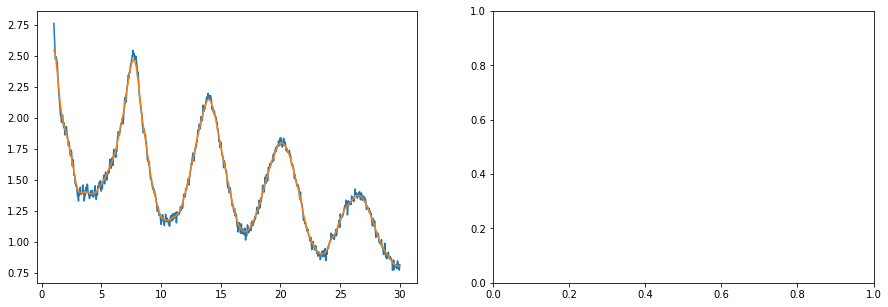

In [199]:
freqs = master_freq
sub_idx = np.logical_and(1 < freqs, freqs < 30)
sub_freq = freqs[sub_idx]
values = df.loc["2020-04-19"].values.mean(axis=0)
# values = -maf(df.loc["2020-04-19"].values.T)[0][:,0]
# values += np.abs(np.min(values))
subset = values[sub_idx]

values += 0.0001
day = np.log(subset * np.exp(5))


a_hat = gaussian_filter1d(day, 6)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(sub_freq, day)
axs[0].plot(sub_freq, a_hat)

# axs[1].plot(sub_freq[1:], da_hat)
# axs[1].plot(sub_freq[true_peaks], da_hat[true_peaks], "o", markersize=10)

# def find_peaks(x)

In [136]:
np.arange(len(main_freq))[ffill(main_freq) > 8.5]

array([301, 517, 541, 660, 829])

took: 0.01s
took: 0.00s
took: 0.87s


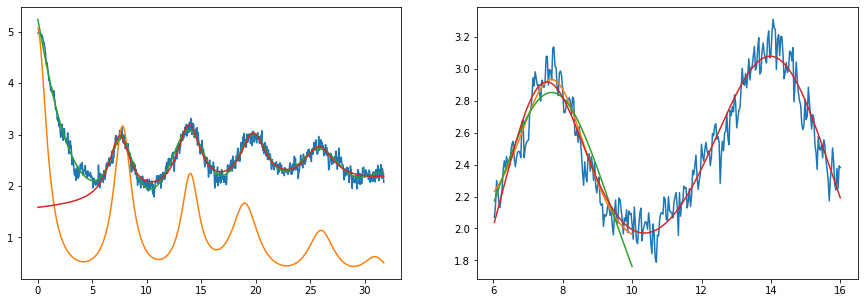

In [359]:
vals = df.loc["2020-04-01":"2020-05-03"].values[:, :1000]
day = np.log(vals[349, :] * np.exp(5))
sub = np.logical_and(sub_freq < 10, sub_freq > 6)
sub2 = np.logical_and(sub_freq < 16, sub_freq > 6)
sub5 = sub_freq > 5
day1 = np.log(vals[349, sub] * np.exp(5))
day2 = np.log(vals[349, sub2] * np.exp(5))
day5 = np.log(vals[349, sub5] * np.exp(5))

p_0 = (0, 7.8, 14, 19, 26, 31, 5, 3, 2, 1.5, 1, 0.5, 2,2,2,3,3,3)
p1_0 = 7.8, np.mean(day1) * 1.5, np.std(day1) * 4
p2_0 = np.append(p1_0, (14.27, 1.4*p1_0[1], p1_0[2]))
p5_0 = (7.8, 14, 19, 26, 31, 3, 2, 1.5, 1, 0.5, 2,2,3,3,3)
# p2_0 = np.append(p1_0, (14.27, 1, 2.8))

import time

s = time.time()
fit = curve_fit(lorentz, sub_freq, day, p0=p_0, jac=jac_lorentzian)
e = time.time()
print(f"took: {e - s:.2f}s")
s = time.time()
fit1 = curve_fit(lorentz1, sub_freq[sub], day1, p0=p1_0, jac=jac_lorentzian1)
e = time.time()
print(f"took: {e - s:.2f}s")

fit2 = curve_fit(lorentz2, sub_freq[sub2], day2, p0=p2_0, jac=jac_lorentzian2)
s = time.time()
fit5 = curve_fit(lorentz5, sub_freq[sub5], day5, jac=jac_lorentzian5, p0=p5_0)
e = time.time()
print(f"took: {e - s:.2f}s")


fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(sub_freq, day)
axs[0].plot(sub_freq, lorentz(sub_freq, 
                                     *p_0))

axs[0].plot(sub_freq, lorentz(sub_freq, 
                                     *fit[0]))
axs[0].plot(sub_freq, lorentz5(sub_freq, *fit5[0]))

axs[1].plot(sub_freq[sub2], day2)

axs[1].plot(sub_freq[sub], lorentz(sub_freq,*fit[0])[sub])

axs[1].plot(sub_freq[sub], lorentz1(sub_freq[sub], *fit1[0]))
axs[1].plot(sub_freq[sub2], lorentz2(sub_freq[sub2], *fit2[0]))

In [302]:
fit[1]

array([[ 1.96720972e-04,  7.39123110e-06, -3.30614904e-05],
       [ 7.39123110e-06,  5.38873843e-04, -7.71737044e-04],
       [-3.30614904e-05, -7.71737044e-04,  2.15841343e-03]])

In [301]:
fits = []
r2 = []
f = master_freq[sub]
vals = np.log(df.loc["2020-03-01":"2020-04-03"].values[:, sub] * np.exp(5))
fit = None
for i, x in enumerate(vals): 
    p1_0 = 7.8, np.mean(x) * 1.5, np.std(x) * 4
    fit = curve_fit(lorentz1, f, x, p0=p1_0, jac=jac_lorentzian1, ftol=1e-5)
    fit6 = curve_fit(lorentz, f, x, p0=p_0, jac=jac_lorentzian, ftol=1e-5)
    x_hat = lorentz1(f, *fit[0])
    res = x - x_hat
    r2.append(1 - np.sum(np.power(res, 2)) / np.sum(np.power(x - np.mean(x), 2)))
    if r2[-1] < 0.5:
        print("Oh no")
        print(i)
    
    fits.append(fit)


KeyboardInterrupt: 

In [207]:
f_sr = []
for fit_i in fits:
    if fit_i is not None:
        f_sr.append(fit_i[0][0])

In [263]:
7.8, np.mean(vals[idx,:]) * 1.5, np.std(vals[idx,:]) * 4

(7.8, 2.3932032149539446, 0.9121653390061627)

In [264]:
r2[idx]

0.4276304689126459

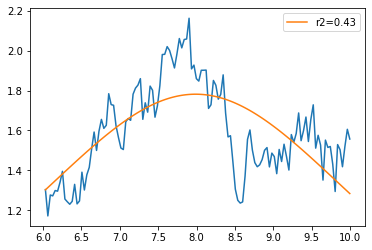

In [265]:
fits[0][0]
idx = 349
plt.plot(master_freq[sub], vals[idx,:])
# plt.plot(master_freq[sub], lorentz1(master_freq[sub], *p1_0))
plt.plot(master_freq[sub], lorentz1(master_freq[sub], *fits[idx][0]), label=f"r2={r2[idx]:.2f}")
plt.legend()

[9.5532]
[0.34912]


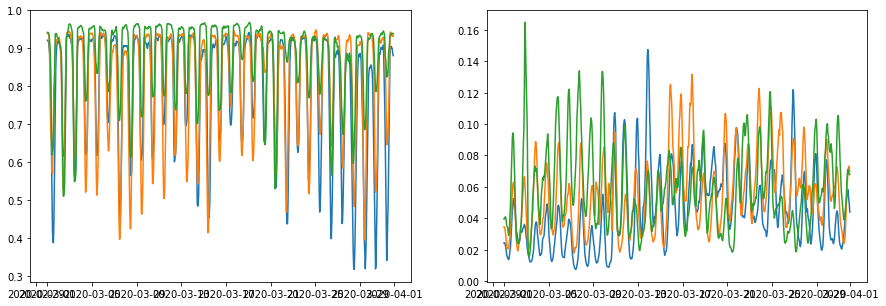

In [9]:
import matplotlib.pylab as plt
from scipy.ndimage import uniform_filter1d, convolve1d

fig, axs = plt.subplots(1, 2, figsize=(15,5))
month = "03"
idx = 10
y1 = df.iloc[:,idx][f"2020-{month}"]
y2 = df.iloc[:,idx][f"2021-{month}"]
y3 = df.iloc[:,idx][f"2022-{month}"]
dates = y1.index
def smooth(x):
    return convolve1d(x, weights=np.ones(7)/7, origin=-1, axis=0)

axs[0].plot(y1.index, smooth(y1.values))
axs[0].plot(y1.index, smooth(y2.values))
axs[0].plot(y1.index, smooth(y3.values))
idx = 300
y1 = df.iloc[:,idx][f"2020-{month}"]
y2 = df.iloc[:,idx][f"2021-{month}"]
y3 = df.iloc[:,idx][f"2022-{month}"]
dates = y1.index
axs[1].plot(y1.index, smooth(y1.values))
axs[1].plot(y1.index, smooth(y2.values))
axs[1].plot(y1.index, smooth(y3.values))

print(master_freq[idx])
print(master_freq[10])

In [353]:
test = np.copy(master_freq)
# test[-1], test[0] = test[0], test[-1]
temp = test[-1]
test[-1] = test[0]
test[0] = temp
test

array([[3.1738e-02],
       [6.3477e-02],
       [9.5215e-02],
       ...,
       [4.9956e+01],
       [4.9988e+01],
       [3.1738e-02]])

In [265]:
values = []
dates = []
for i, test in df.groupby([pd.Grouper(freq='W-MON')]):
    if len(test) == 0:
        continue
    values.append(test.mean(axis=0))
    dates.append(test.index[0].date())
weekly = pd.DataFrame(index=dates, data=values)
weekly.head()

,0,1,2,3,4,5,6,7,8,9,...,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575
2019-01-01,0.940681,0.973068,0.963241,0.944471,0.925985,0.912257,0.896431,0.884355,0.868968,0.850654,...,0.226362,0.245727,0.194639,0.106110,0.058208,0.059715,0.104326,0.129917,0.098003,0.051366
2019-01-08,0.938165,0.971564,0.959074,0.933382,0.915568,0.902753,0.891613,0.875753,0.861975,0.843403,...,0.479020,0.428346,0.286978,0.134257,0.061550,0.066765,0.100602,0.112895,0.085271,0.045146
2019-01-15,0.935659,0.971418,0.960434,0.939546,0.925012,0.911458,0.898761,0.885602,0.872293,0.859030,...,0.423515,0.423716,0.325193,0.186842,0.117001,0.141497,0.140588,0.128536,0.097850,0.058969
2019-01-22,0.938414,0.973152,0.962894,0.944286,0.923490,0.905700,0.892425,0.879295,0.862772,0.846054,...,0.325147,0.339012,0.263517,0.137011,0.066088,0.055641,0.086227,0.106897,0.086434,0.050947
2019-01-29,0.939824,0.972208,0.960047,0.941179,0.921912,0.907027,0.900369,0.884571,0.871377,0.850802,...,0.330177,0.314029,0.216815,0.104248,0.052383,0.054249,0.090565,0.113686,0.091178,0.044229


In [342]:
# Switch
weekly.iloc[:, 0], weekly.iloc[:, -1] = weekly.iloc[:, -1], weekly.iloc[:, 0]



In [394]:
weekly.index = pd.to_datetime(weekly.index)

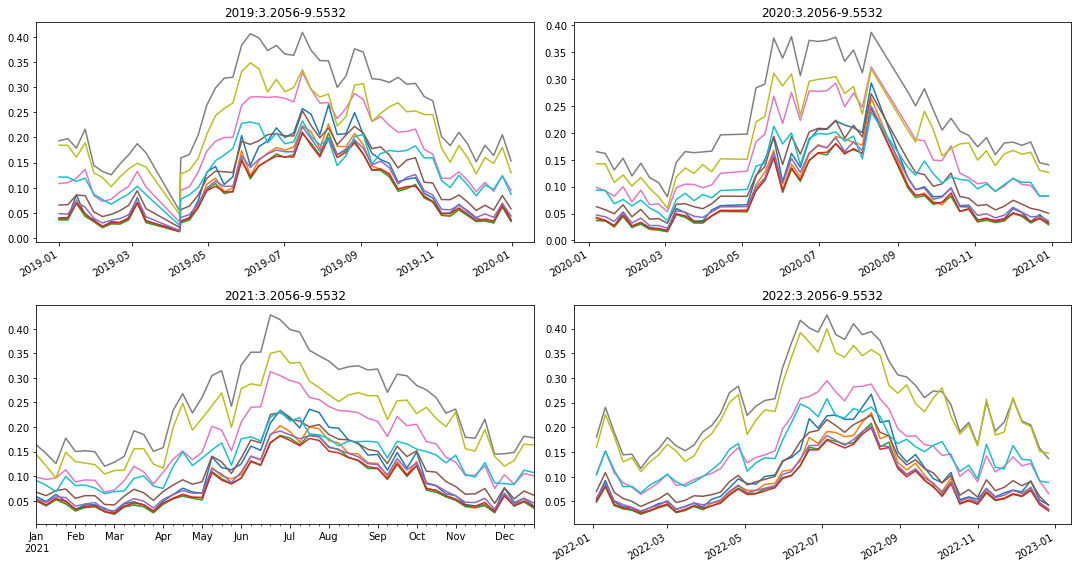

In [418]:
idx = 100
fig, axs = plt.subplots(2, 2, figsize=(15,8))
N = 200
for i in np.arange(0, N, 20):
    weekly.loc["2019"].iloc[:, idx + i].plot(ax=axs[0,0], title=f"{2019}:{master_freq[idx]}-{master_freq[idx+N]}")
    weekly.loc["2020"].iloc[:, idx + i].plot(ax=axs[0,1], title=f"{2020}:{master_freq[idx]}-{master_freq[idx+N]}")
    weekly.loc["2021"].iloc[:, idx + i].plot(ax=axs[1,0], title=f"{2021}:{master_freq[idx]}-{master_freq[idx+N]}")
    weekly.loc["2022"].iloc[:, idx + i].plot(ax=axs[1,1], title=f"{2022}:{master_freq[idx]}-{master_freq[idx+N]}")

fig.tight_layout()

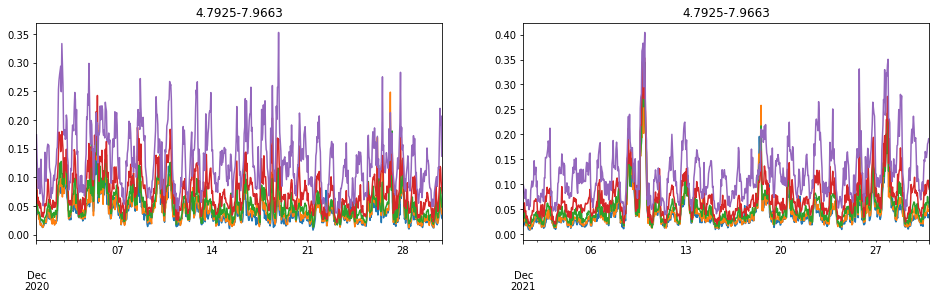

In [510]:
idx = 150
fig, axs = plt.subplots(1, 2, figsize=(16,4))
N = 100
start_date = "12-01"
end_date = "12-30"
for i in np.arange(0, N, 20):
    df.loc[f"2020-{start_date}":f"2020-{end_date}"].iloc[:, idx + i].plot(ax=axs[0], title=f"{master_freq[idx]}-{master_freq[idx+N]}")
    df.loc[f"2021-{start_date}":f"2021-{end_date}"].iloc[:, idx + i].plot(ax=axs[1], title=f"{master_freq[idx]}-{master_freq[idx+N]}")



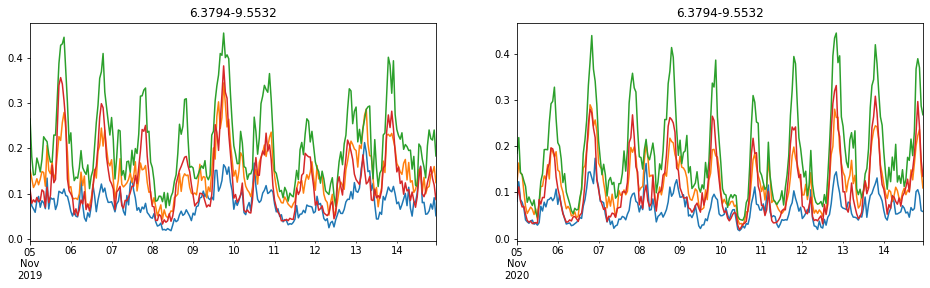

In [512]:
idx = 200
fig, axs = plt.subplots(1, 2, figsize=(16,4))
N = 100
for i in np.arange(0, N, 25):
    df.loc["2019-11-05":"2019-11-14"].iloc[:, idx + i].plot(ax=axs[0], title=f"{master_freq[idx]}-{master_freq[idx+N]}")
    df.loc["2020-11-05":"2020-11-14"].iloc[:, idx + i].plot(ax=axs[1], title=f"{master_freq[idx]}-{master_freq[idx+N]}")



<AxesSubplot:title={'center':'2020-08-11'}>

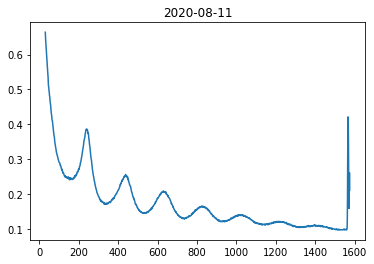

In [373]:
idx = 80
weekly.iloc[idx, master_freq>1].plot(title=f"{weekly.index.values[idx]}")


Text(0.5, 0, 'Power [pT]')

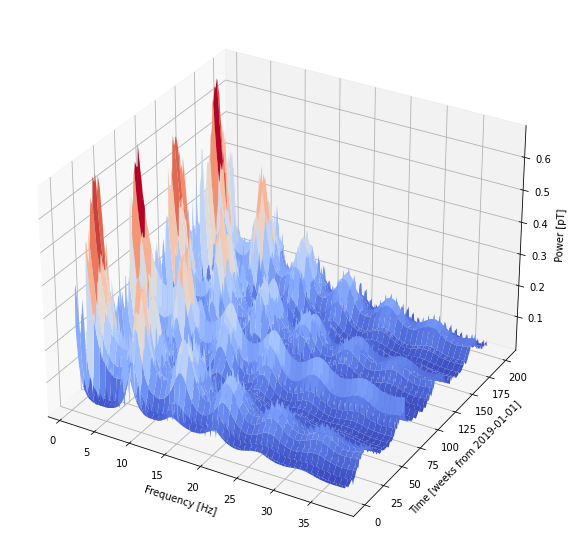

In [499]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
min_freq_idx = np.logical_and((master_freq.flatten() < 38), (master_freq.flatten() > 1))
X, Y = np.meshgrid(master_freq[min_freq_idx], np.arange(len(weekly.index)))
# X, Y = np.meshgrid(master_freq[min_freq_idx], weekly.index)


surf = ax.plot_surface(X, Y, weekly.values[:, min_freq_idx], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Time [weeks from 2019-01-01]')
labels = [item.get_text() for item in ax.get_yticklabels()]
# ax.set_yticklabels(labels)
# ax.yaxis.set_ticks(x)
# ax.set_yticklabels([weekly.index.values[l] for l in labels])
# ax.yaxis.set_ticklabels(dates_formatted)
ax.set_zlabel('Power [pT]')

In [528]:
weekly.values[:, min_freq_idx][subset_time,:].shape

(51, 1166)

Text(0.5, 0, 'Power [pT]')

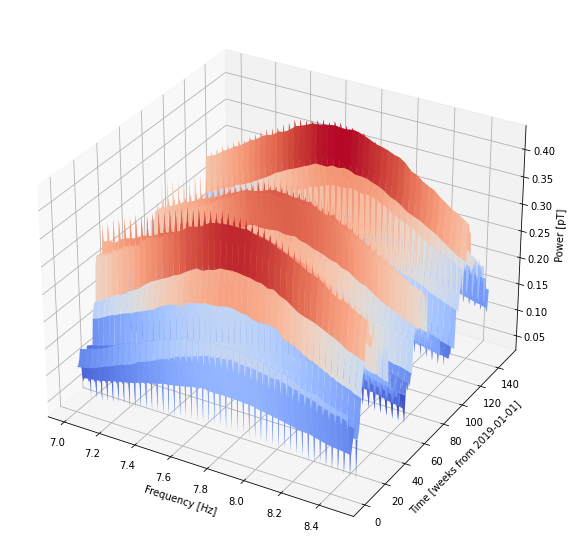

In [536]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
min_freq_idx = np.logical_and((master_freq.flatten() < 8.5), (master_freq.flatten() > 7))
subset_time = weekly.index.values < np.datetime64("2022")

X, Y = np.meshgrid(master_freq[min_freq_idx], np.arange(len(weekly.index[subset_time])))
# X, Y = np.meshgrid(master_freq[min_freq_idx], weekly.index)


surf = ax.plot_surface(X, Y, weekly.values[:, min_freq_idx][subset_time,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Time [weeks from 2019-01-01]')
labels = [item.get_text() for item in ax.get_yticklabels()]
# ax.set_yticklabels(labels)
# ax.yaxis.set_ticks(x)
# ax.set_yticklabels([weekly.index.values[l] for l in labels])
# ax.yaxis.set_ticklabels(dates_formatted)
ax.set_zlabel('Power [pT]')


In [539]:
np.diff(master_freq)[:40]

array([0.031739, 0.031738, 0.031735, 0.03174 , 0.03174 , 0.03174 ,
       0.03174 , 0.03173 , 0.03174 , 0.03174 , 0.03174 , 0.03174 ,
       0.03174 , 0.03173 , 0.03174 , 0.03174 , 0.03174 , 0.03174 ,
       0.03174 , 0.03173 , 0.03174 , 0.03174 , 0.03174 , 0.03174 ,
       0.03174 , 0.03173 , 0.03174 , 0.03174 , 0.03174 , 0.03174 ,
       0.03171 , 0.0318  , 0.0317  , 0.0317  , 0.0318  , 0.0317  ,
       0.0318  , 0.0317  , 0.0317  , 0.0318  ])

In [129]:
f = files[1]
month = re.search(patterns, str(f)).group(2)
day = re.search(patterns, str(f)).group(3)
year = re.search(patterns, str(f)).group(1)
date = np.datetime64(f"{year}-{month}-{day}")
data = pd.read_csv(f, delimiter="\t")
data = data.rename({"-10": "freq"}, axis=1)
pivot = data.T
freq = pivot.iloc[0,:].values
pivot = pivot.iloc[1:,:]
hour = [f"{int(s)-1}" if int(s) > 10 else f"0{int(s)-1}" for s in pivot.index]
datetime = [np.datetime64(f"{year}-{month}-{day} {h}:00:00") for h in hour]
pivot.index = datetime
pivot.head()

,0,1,2,3,4,5,6,7,8,9,...,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575
2022-06-26 00:00:00,0.96858,0.98333,0.98333,0.98333,0.96895,0.96628,0.97702,0.96641,0.96952,0.96118,...,0.57731,0.55884,0.40676,0.19353,0.079352,0.088390,0.28383,0.35733,0.25132,0.104600
2022-06-26 01:00:00,0.96841,0.98333,0.98333,0.98237,0.97845,0.98333,0.98103,0.97543,0.97602,0.94296,...,0.54345,0.61669,0.43503,0.22970,0.117020,0.146380,0.26575,0.33919,0.27284,0.087501
2022-06-26 02:00:00,0.95770,0.97500,0.97500,0.97500,0.97500,0.97500,0.97500,0.96137,0.96070,0.95349,...,0.49105,0.43880,0.40682,0.27856,0.092230,0.060379,0.18634,0.19075,0.16444,0.095647
2022-06-26 03:00:00,0.96670,0.97500,0.97500,0.96745,0.97500,0.97500,0.95983,0.97500,0.93899,0.95275,...,0.13921,0.37767,0.60122,0.65651,0.371990,0.129670,0.17157,0.18043,0.12779,0.050026
2022-06-26 04:00:00,0.95981,0.96745,0.97020,0.97500,0.96689,0.95727,0.96737,0.95297,0.97049,0.94863,...,0.40620,0.49728,0.49199,0.37050,0.200560,0.090231,0.19682,0.24209,0.18342,0.099618


In [126]:
np.datetime64(f"{year}-{month}-{day} {hour[23]}:00:00")

numpy.datetime64('2022-06-26T23:00:00')

In [127]:
datetime = [np.datetime64(f"{year}-{month}-{day} {h}:00:00") for h in hour]

In [128]:
datetime


[numpy.datetime64('2022-06-26T00:00:00'),
 numpy.datetime64('2022-06-26T01:00:00'),
 numpy.datetime64('2022-06-26T02:00:00'),
 numpy.datetime64('2022-06-26T03:00:00'),
 numpy.datetime64('2022-06-26T04:00:00'),
 numpy.datetime64('2022-06-26T05:00:00'),
 numpy.datetime64('2022-06-26T06:00:00'),
 numpy.datetime64('2022-06-26T07:00:00'),
 numpy.datetime64('2022-06-26T08:00:00'),
 numpy.datetime64('2022-06-26T09:00:00'),
 numpy.datetime64('2022-06-26T10:00:00'),
 numpy.datetime64('2022-06-26T11:00:00'),
 numpy.datetime64('2022-06-26T12:00:00'),
 numpy.datetime64('2022-06-26T13:00:00'),
 numpy.datetime64('2022-06-26T14:00:00'),
 numpy.datetime64('2022-06-26T15:00:00'),
 numpy.datetime64('2022-06-26T16:00:00'),
 numpy.datetime64('2022-06-26T17:00:00'),
 numpy.datetime64('2022-06-26T18:00:00'),
 numpy.datetime64('2022-06-26T19:00:00'),
 numpy.datetime64('2022-06-26T20:00:00'),
 numpy.datetime64('2022-06-26T21:00:00'),
 numpy.datetime64('2022-06-26T22:00:00'),
 numpy.datetime64('2022-06-26T23:0

In [67]:
f = files[0]
month = re.search(patterns, str(f)).group(2)
day = re.search(patterns, str(f)).group(3)
year = re.search(patterns, str(f)).group(1)
date = np.datetime64(f"{year}-{month}-{day}")
data = pd.read_csv(f, delimiter="\t")
data["date"] = date
data.head()
pivot = data.T
pivot.set_axis(pivot.iloc[0,:], axis=1, inplace=True)
pivot = pivot.iloc[1:,:]
pivot.head()

-10,0.031738,0.063477,0.095215,0.126950,0.158690,0.190430,0.222170,0.253910,0.285640,0.317380,...,49.734000,49.766000,49.797000,49.829000,49.861000,49.893000,49.924000,49.956000,49.988000,0.000000
1,0.94974,0.97945,0.98333,0.98333,0.97623,0.98333,0.98034,0.96333,0.97541,0.97848,...,0.48984,0.37386,0.22637,0.12399,0.059342,0.052015,0.13289,0.18599,0.15828,0.071363
2,0.96694,0.98333,0.98036,0.9741,0.98333,0.97859,0.9714,0.97701,0.96826,0.95681,...,0.4298,0.32737,0.2233,0.085785,0.051142,0.10565,0.17702,0.21829,0.19666,0.054013
3,0.92252,0.975,0.975,0.975,0.975,0.975,0.96698,0.96136,0.9665,0.95758,...,0.45105,0.67358,0.46296,0.14374,0.023608,0.033411,0.1189,0.16974,0.14877,0.03896
4,0.94021,0.975,0.975,0.96944,0.975,0.97456,0.975,0.96718,0.96761,0.96802,...,0.46421,0.43783,0.21512,0.053996,0.023945,0.05167,0.10746,0.11312,0.1315,0.059289
5,0.93944,0.96777,0.975,0.975,0.971,0.97183,0.95672,0.96348,0.96379,0.94716,...,0.57919,0.47732,0.2484,0.068483,0.016332,0.031408,0.10317,0.13306,0.16482,0.10935
